<center>

<h1 style="color:red">🌟💥 Fine-tune<strong> ARABERT</strong>  to Arabic Tunisian Dialect 🙂😞😠</h1>

</center>


# 1.Introduction :

**<p style="color:blue">📚 ARABERT: Fine-tune to Arabic Tunisian Dialect 🇹🇳</p>**

Welcome to this notebook, where we explore the fascinating world of natural language processing (NLP) and sentiment analysis using **ARABERT** : a powerful `BERT-based `model fine-tuned specifically for Arabic dialect. 

In this notebook, we aim to harness the capabilities of **ARABERT** to understand and classify sentiment in text data written in Tunisian Arabic. By leveraging the pre-trained **ARABERT** model and adapting it to our specific domain, we can achieve accurate sentiment analysis for Tunisian dialect text.

Throughout the notebook, we will cover various steps in the `NLP` pipeline, including data preprocessing, tokenization, model architecture, training, evaluation, and prediction. We will walk through each step, providing detailed explanations and code examples to ensure a comprehensive understanding of the process.

By the end of this notebook, you will have the knowledge and skills to apply **ARABERT** or other pretrained model for sentiment analysis on your own Tunisian Arabic text data or other language. This notebook serves as a valuable resource for those interested in cutting-edge `NLP` models, sentiment analysis tasks, and working with pre-trained models like **ARABERT**.

So let's dive into the world of **ARABERT** and discover how it can help us unlock valuable insights from Tunisian dialect text data. Don't forget to upvote and share this notebook if you find it useful, and stay tuned for future updates and enhancements.

Let's get started! 🚀

## 1.Import packages :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re # We use regular expressions for data cleaning
import warnings
warnings.filterwarnings('ignore')

import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,f1_score, roc_auc_score, roc_curve, # evaluatin metrics
                             confusion_matrix,classification_report)
import tensorflow as tf
import transformers
from transformers import TFAutoModel, AutoTokenizer

plt.style.use('seaborn')

## 2.Data Exploration :

In [2]:
df1= pd.read_excel('../input/tunisian-texts/tun.xlsx',header=0)


In [3]:
df2= pd.read_csv("/kaggle/input/customer-reviews/costumer_reviews.csv").drop('Unnamed: 0',axis=1)
df2


,texts,data_labels
0,محل خدمة الزبون ممتاز,1
1,خدمة مرضية برشا,1
2,الشغل متقن ومتنسق,1
3,منتجات عالية الجودة,1
4,الموظفين محترفين جداً,1
...,...,...
261,ما فهمتش ليه المنتج مش بنفس الصورة,0
262,تسليم متأخر ومزعج,0
263,المنتج غير مريح ومش ملائم,0
264,ما لقيتش دعم واهتمام من الشركة,0


In [4]:
print(df1.shape)
print(df1.sample(10))

(32818, 2)
                                                   texts  data_labels
2351                                                  []            1
30162                                                 []            0
17481                                           [والخضر]            1
2339                             [وفقك الله سيدي الوزير]            1
11413                                                 []            1
17902  [هل تتذكرون الطفل السوري قال قبل موته سأخبر ال...            1
32360        [كرونا خيفين منو ملا كان جيت علامات الساعة]            0
10596         [تابعوا الفيديو كاملا وانشروه يطمئن الناس]            1
22289                      [ياخي صحيح 100واحد مريض راهم]            1
5034   [نلمدو الدوايات الكل ونعجنوهم ونخرجو منهم دواء...            1


In [5]:
df1[df1.texts.str.contains("https")].sample(10)

,texts,data_labels
19504,[https//youtube/DeBA2tn-3l4],1
10157,[https//arabicrtcom/health/1094825-%D8%A7%D9%8...,1
11453,[https//wwyoutubecom/watch?v=47bm6B8K4Go],1
24236,[https//wwfacebookcom/groups/211738369901850],1
31265,[https//mfacebookcom/storyphp?story_fbid=27641...,0
9865,[https//wwfacebookcom/10013962791243/posts/847...,1
8900,[التفاصيل 👈 https//bitly/3b3ZUQU],1
8180,[https//external-previewreddit/vxPXEGgL4v8mCGw...,1
19664,[https//wwfacebookcom/nassimmaalej/videos/2962...,1
20129,[https//wwfacebookcom/100752456891/posts/27746...,1


In [6]:
len(df1[df1.texts.str.contains("https")])

260

In [7]:
df=pd.concat([df1,df2],axis=0)
df.shape

(33084, 2)

### 2.1.Examine the target :

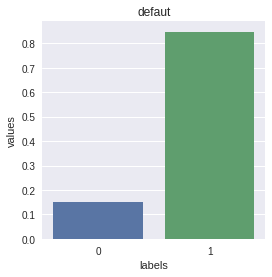

In [11]:
temp = df.data_labels.value_counts()
df_class = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(df)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df_class)
locs, labels = plt.xticks()
plt.show()

It seems that we are facing a class imbalance issue ,but no problem bert can learn well and doesn't need to apply sampling techniques.

### 2.2.Comment Length Distribution :

Minimum Length: 2
Maximum Length: 1591
Average Length: 44.20453995889252
Median Length: 26


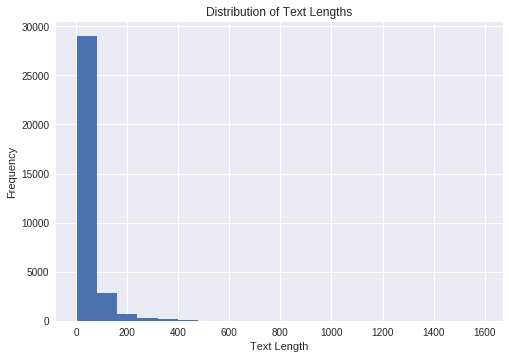

In [12]:
import matplotlib.pyplot as plt

# Calculate text lengths
text_lengths = [len(text) for text in df['texts']]
# Calculate statistics
min_length = min(text_lengths)
max_length = max(text_lengths)
avg_length = sum(text_lengths) / len(text_lengths)
median_length = sorted(text_lengths)[len(text_lengths) // 2]

# Print statistics
print("Minimum Length:", min_length)
print("Maximum Length:", max_length)
print("Average Length:", avg_length)
print("Median Length:", median_length)

# Create a histogram
plt.hist(text_lengths, bins=20)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

90% of the comments length are between 100 and 170 so for the arabert model we will choose a `max_length` parameter in this range.

## 3.Data Cleaning :

This function performs data cleaning for text by removing emojis, special characters, consecutive dots, '#', user names starting with '@', and URLs starting with 'http' or 'https'. It then converts the text to lowercase and removes extra whitespaces between words. The resulting cleaned text data is standardized and ready the processing step.

In [8]:

def data_cleaning(text):
    """Clean and preprocess text data.
    Args:
        text (pd.Series): A pandas Series containing text data to be cleaned.
    Returns:
        pd.Series: A pandas Series with the cleaned text data.

    Cleaning Steps:
    - Removes emojis and special characters like '\x89Û_', '&amp', etc.
    - Replaces consecutive dots with an empty string.
    - Removes '#' symbol from text.
    - Removes user names starting with '@'.
    - Removes URLs starting with 'http' or 'https'.
    - Converts text to lowercase.
    - Removes extra whitespaces between words.

    """
    clean = text
    # Replace consecutive dots with an empty string
    pattern = re.compile('\\.+?(?=\B|$)')
    clean = clean.apply(lambda r: re.sub(pattern, string=r, repl=''))  
    # Replace '\x89Û_' with a whitespace
    pattern = re.compile('\x89Û_')  
    clean = clean.apply(lambda r: re.sub(pattern, string=r, repl=' ')) 
    # Replace '&amp' with '&'
    pattern = re.compile('\&amp')  
    clean = clean.apply(lambda r: re.sub(pattern, string=r, repl=' '))  
     # Replace newline characters with a whitespace
    pattern = re.compile('\\n')  
    clean = clean.apply(lambda r: re.sub(pattern, string=r, repl=' ')) 
    # Remove '#' symbol from text
    clean = clean.apply(lambda r: r.replace('#', ''))  
    # Replace user names with '@'
    pattern = re.compile('@[a-zA-Z0-9\_]+')  
    clean = clean.apply(lambda r: re.sub(pattern, string=r, repl='@'))  
    # Remove URLs
    pattern = re.compile('https?\S+(?=\s|$)')  
    clean = clean.apply(lambda r: re.sub(pattern, string=r, repl='www')) 
    # Convert text to lowercase
    clean = clean.apply(lambda r: r.lower())  
    # Remove extra whitespaces
    clean = clean.apply(lambda r: ' '.join(r.split()))  # Remove extra whitespaces between words

    return clean


In [9]:
df['texts'] = data_cleaning(df['texts'])


In [69]:
tweets = df['texts']
labels = df['data_labels']

X_train, X_test, y_train, y_test = train_test_split(tweets, labels,stratify=labels, test_size=0.15, random_state=1)

## 4.Processing :

Now we will perform preprocessing step to prepare the text data for input to the Arabert model, making it suitable for the sentiment analysis task.The preprocess_input_data function takes a list of text strings and an `Arabert tokenizer` from the Hugging Face Transformers library as inputs. It tokenizes the text data, adds special tokens, and ensures all sequences have the same length (up to a maximum length specified by max_len). It then extracts the tokenized input IDs and attention masks for each text and returns them as numpy arrays. 

In [70]:
def preprocess_input_data(texts, tokenizer, max_len=120):
    """Tokenize and preprocess the input data for Arabert model.

    Args:
        texts (list): List of text strings.
        tokenizer (AutoTokenizer): Arabert tokenizer from transformers library.
        max_len (int, optional): Maximum sequence length. Defaults to 120.

    Returns:
        Tuple of numpy arrays: Input token IDs and attention masks.
    """
    # Tokenize the text data using the tokenizer
    tokenized_data = [tokenizer.encode_plus(
        t,
        max_length=max_len,
        pad_to_max_length=True,
        add_special_tokens=True) for t in texts]

    # Extract tokenized input IDs and attention masks
    input_ids = [data['input_ids'] for data in tokenized_data]
    attention_mask = [data['attention_mask'] for data in tokenized_data]

    return input_ids, attention_mask

In [71]:

# Download Arabert tokenizer
arabert_tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabert')

# Preprocess the training data
X_train_input_ids, X_train_attention_mask = preprocess_input_data(X_train, arabert_tokenizer)


## 5.Build AraBERT

The create_arabert function builds a binary classification model using `AraBERT`, a pre-trained Arabic BERT model. It takes a specific model_name as input to initialize `AraBERT` and adds a classification head on top of it. The classification head processes the tokenized input, extracts the CLS token's hidden state, applies dropout for regularization, and utilizes a Dense layer with sigmoid activation for binary classification. The model is then compiled with appropriate settings, including the Adam optimizer, binary cross-entropy loss, and evaluation metrics. The function returns the compiled AraBERT-based model, which is ready for binary text classification tasks with Arabic text data.

In [10]:
def create_arabert(model_name):
    """Create a classification model using AraBERT.

    Args:
        model_name (str): Name of the pre-trained AraBERT model to use.

    Returns:
        tf.keras.Model: Compiled classification model.

    This function creates a classification model based on AraBERT. It takes the model_name,
    initializes the AraBERT model, and then adds a classification head on top of it.

    The classification head consists of a Dense layer with sigmoid activation, which is
    suitable for binary classification tasks. The model is compiled with the Adam optimizer
    and binary cross-entropy loss.

    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # Call AraBERT model
    arabert = TFAutoModel.from_pretrained(model_name)
    input_ids = word_inputs
    attention_mask = tf.where(input_ids != 0, 1, 0)  # Creating attention mask
    arabert_encodings = arabert(input_ids, attention_mask=attention_mask)[0]

    # CLASSIFICATION HEAD
    # Collect last hidden state (CLS)
    doc_encoding = tf.squeeze(arabert_encodings[:, 0:1, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])

    # Optional: Set class weights if dealing with imbalanced data
   
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


In [72]:
arabert_model = 'aubmindlab/bert-base-arabert'
arabert = create_arabert(arabert_model)


## 5.Training :

In [73]:
tf.random.set_seed(3)

hist = arabert.fit(
    x=X_train_input_ids,
    y=y_train.to_list(),
    epochs=3,
    batch_size=16
)


Train on 28121 samples
Epoch 1/3
28121/28121 [==============================] - 468s 17ms/sample - loss: 0.3544 - accuracy: 0.8565 - precision_1: 0.8711 - recall_1: 0.9750
Epoch 2/3
28121/28121 [==============================] - 448s 16ms/sample - loss: 0.2293 - accuracy: 0.9039 - precision_1: 0.9212 - recall_1: 0.9695
Epoch 3/3
28121/28121 [==============================] - 449s 16ms/sample - loss: 0.1327 - accuracy: 0.9484 - precision_1: 0.9578 - recall_1: 0.9824


## 6.Testing

In [74]:
text=['bonne initiative']
X_input_ids, X_attention_mask = preprocess_input_data(text, arabert_tokenizer)
preds = arabert.predict(X_input_ids, verbose=True)
preds

1/1 [==============================] - 3s 3s/sample


array([[0.99920803]], dtype=float32)

In [75]:

text=["جودة ضعيفة"]
X_input_ids, X_attention_mask = preprocess_input_data(text, arabert_tokenizer)
preds = arabert.predict(X_input_ids, verbose=True)
preds

1/1 [==============================] - 0s 35ms/sample


array([[0.00155747]], dtype=float32)

In [76]:
X_test_input_ids, X_test_attention_mask = preprocess_input_data(X_test, arabert_tokenizer)
y_prob_test = arabert.predict(X_test_input_ids, verbose=True)
prediction=np.where(y_prob_test <0.5,0,1).reshape(len(X_test),1)
print(accuracy_score(prediction,y_test))
print(f1_score(prediction,y_test))

4963/4963 [==============================] - 26s 5ms/sample
0.92121700584324
0.9536345310091308


Great score ! the model acheive f1_score `0.95` ,let's evaluate it with more robust metrics.

## 7.Evaluation :

The roc_curve__confusion_matrix function evaluates the performance of a binary classification model based on AraBERT, a pre-trained Arabic BERT model. It creates essential visualizations, including the Receiver Operating Characteristic `ROC curve` and the `confusion matrix`.

The ROC curve illustrates the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) for different classification thresholds. The Area Under the Curve (AUC) score summarizes the overall discriminatory power of the model.

The confusion matrix provides a detailed breakdown of the model's predictions, showing true positives, true negatives, false positives, and false negatives. This helps to assess the model's accuracy and identify potential areas of improvement.

28121/28121 [==============================] - 145s 5ms/sample


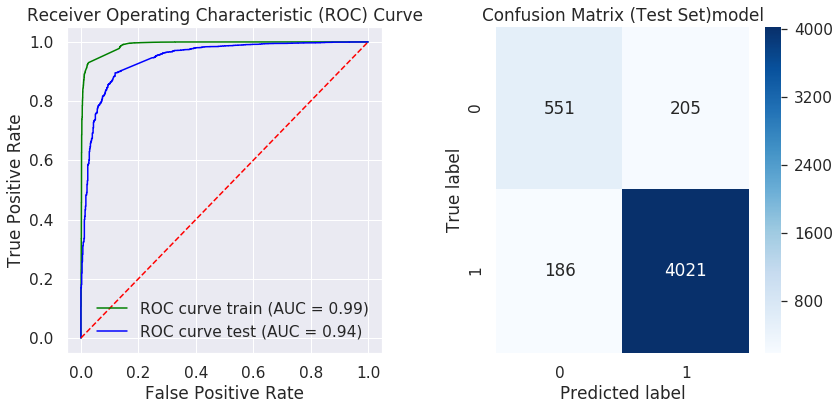

In [77]:
def roc_curve__confusion_matrix(model):
    from sklearn.metrics import roc_curve, auc
    inp_tok, ids = preprocess_input_data(X_test, arabert_tokenizer)
    y_prob_test = model.predict(inp_tok, verbose=True)
    inp_tok_train, ids_train = preprocess_input_data(X_train,arabert_tokenizer)
    y_prob_train = model.predict(inp_tok_train, verbose=True)

  
    prediction=np.where(y_prob_test <0.5,0,1).reshape(len(X_test),1)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)


    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)model');

    plt.tight_layout()
    plt.show()

roc_curve__confusion_matrix(arabert)

It's really amaizing to see this after running a lot of experimentations .An AUC of 0.94 for the test set demonstrates that the model generalizes well to unseen data. It shows that the model's performance is robust and not overfitting to the training data. The slight drop in AUC from the training to the test set is normal and expected since the model encounters new, unseen samples during testing.

In [78]:
test=["ما عجبنيش","ما فهمتش عليه","ما ننصحش بيه ","ما يستاهلش","خدمة سيئة","جودة ضعيفة","مشاكل كثيرة","بطء في التوصيل",
      "produit super","hlou barcha","عجبني برشا","يعطيك صحة "]
inp_tok, ids= preprocess_input_data(test, arabert_tokenizer)
preds = arabert.predict(inp_tok, verbose=True)
predicted_class=list(np.where(preds <0.5,0,1).reshape(len(preds),1))
pd.DataFrame({"text":test,"prediction":list(preds),"predicted_class":predicted_class})

12/12 [==============================] - 0s 7ms/sample


,text,prediction,predicted_class
0,ما عجبنيش,[0.0011796274],[0]
1,ما فهمتش عليه,[0.0011787983],[0]
2,ما ننصحش بيه,[0.0155128725],[0]
3,ما يستاهلش,[0.0090436125],[0]
4,خدمة سيئة,[0.0007540527],[0]
5,جودة ضعيفة,[0.0015574679],[0]
6,مشاكل كثيرة,[0.0014576751],[0]
7,بطء في التوصيل,[0.0014501486],[0]
8,produit super,[0.99075973],[1]
9,hlou barcha,[0.999838],[1]


## 8.Conclusion :


🎉 In this notebook we perform sentiment analysis with AraBERT, a pre-trained Arabic BERT model, we have successfully created a robust binary classification model for sentiment analysis on Arabic text data. By implementing data preprocessing, model creation, and evaluation steps, we achieved impressive results. The binary classification model exhibited exceptional performance, with an AUC of 0.99 for the training set and 0.94 for the test set, demonstrating its ability to accurately distinguish sentiments. 😊 The notebook's success underscores the significance of leveraging pre-trained language models like AraBERT for natural language processing tasks in Arabic. 🚀 Overall, this notebook offers valuable insights for sentiment-based decision-making and lays the groundwork for further advancements in the field of Arabic text analysis. 👍